In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [3]:
from themis_ml.datasets import german_credit
credit = german_credit(raw=True)
credit.head(2)

,status_of_existing_checking_account,duration_in_month,credit_history,purpose,credit_amount,savings_account/bonds,present_employment_since,installment_rate_in_percentage_of_disposable_income,personal_status_and_sex,other_debtors/guarantors,...,property,age_in_years,other_installment_plans,housing,number_of_existing_credits_at_this_bank,job,number_of_people_being_liable_to_provide_maintenance_for,telephone,foreign_worker,credit_risk
0,1,6,critical_account/other_credits_existing_not_at...,radio/television,1169,0,4,4,male_single,none,...,real_estate,67,none,own,2,2,1,1,1,1
1,2,48,existing_credits_paid_back_duly_till_now,radio/television,5951,1,2,2,female_divorced/separated/married,none,...,real_estate,22,none,own,1,2,1,0,1,0


In [4]:
def preprocessGermanCredit(temp_df):
    """
    Preprocess German Credit dataset

    credit_risk                                            int64
    duration_in_month                                      int64
    credit_amount                                          int64
    installment_rate_in_percentage_of_disposable_income    int64
    age                                                    int64
    credit_history                                         int64
    housing                                                int64
    status_of_existing_checking_account                    int64
    present_employment_since                               int64
    purpose                                                int64
    dtype: object
    """
    df = temp_df.copy()
    
    df['credit_amount'] /= 500
    df['credit_amount'] = df['credit_amount'].astype(int)
    df.loc[df['age_in_years'] <= 25, 'age'] = 1 
    df.loc[df['age_in_years'] > 25, 'age'] = 0
    df['age'] = df['age'].astype(int)
    # categorical_features 
    housing = {2: 'for free', 1: 'own',  0: 'rent'}
    credit_history = {0: 'no_credits_taken/all_credits_paid_back_duly', 
                        1: 'all_credits_at_this_bank_paid_back_duly',
                        2: 'existing_credits_paid_back_duly_till_now', 
                        3: 'delay_in_paying_off_in_the_past',
                        4: 'critical_account/other_credits_existing_not_at_this_bank',
                    }
    
    df["credit_history"] = df["credit_history"].map({v: k for k, v in credit_history.items()})
    df["housing"] = df["housing"].map({v: k for k,v in housing.items()})
    df['purpose'] = pd.factorize(df['purpose'])[0]

    df = df[['duration_in_month', 'credit_amount', 'installment_rate_in_percentage_of_disposable_income', 'age', 'credit_history', 'housing','status_of_existing_checking_account','present_employment_since', 'purpose', 'credit_risk']]
    return df


In [5]:
df = preprocessGermanCredit(credit)

In [6]:
def german_classification_helper(synthesizer, eps, rep, classifier, test_df, non_priv_results=False):
    """ helper function to calculate TPR_diff, FPR_diff, and F1_score for a single synthesizer, eps, rep, and classifier """
    
    # Read in the synthetic training data or use non-private data
    if non_priv_results:
        train_df = non_priv_train
    else:
        fname = f"{synthesizer}/German_{synthesizer}_eps={eps}_{rep}.csv" 
        train_df = pd.read_csv(fname, index_col=0)

    # Train the classification model
    X_train, y_train = train_df.drop(["credit_risk","age"], axis=1), train_df["credit_risk"]
    X_test, y_test = test_df.drop(["credit_risk","age"], axis=1), test_df["credit_risk"]
    if len(np.unique(y_train)) != 2:
        return None
    if classifier == "logistic":
        m = LogisticRegression(max_iter=1000, C=1., penalty="l2")
        m.fit(X_train, y_train)
    elif classifier == "forest":
        m = RandomForestClassifier(random_state=0)
        m.fit(X_train, y_train)
    else:
        raise Exception(f"Classifier {classifier} not recognized.")

    # Predict on the test set
    y_test_pred = m.predict(X_test)

    # Get the all classification metrics on the test set
    df = test_data.copy() # test_df
    df["y"] = y_test
    df["y_pred"] = y_test_pred
    
    TP_f = len(df[(df["age"]==0) & (df["y"]==1) & (df["y_pred"]==1)])
    TP_m = len(df[(df["age"]==1) & (df["y"]==1) & (df["y_pred"]==1)])
    FP_f = len(df[(df["age"]==0) & (df["y"]==0) & (df["y_pred"]==1)])
    FP_m = len(df[(df["age"]==1) & (df["y"]==0) & (df["y_pred"]==1)])
    TN_f = len(df[(df["age"]==0) & (df["y"]==0) & (df["y_pred"]==0)])
    TN_m = len(df[(df["age"]==1) & (df["y"]==0) & (df["y_pred"]==0)])
    FN_f = len(df[(df["age"]==0) & (df["y"]==1) & (df["y_pred"]==0)])
    FN_m = len(df[(df["age"]==1) & (df["y"]==1) & (df["y_pred"]==0)])
    TPR_f = TP_f / (TP_f + FN_f)
    TPR_m = TP_m / (TP_m + FN_m)
    FPR_f = FP_f / (FP_f + TN_f)
    FPR_m = FP_m / (FP_m + TN_m)
    TPR_diff = TPR_m - TPR_f
    FPR_diff = FPR_m - FPR_f
    f1_score = (TP_f+TP_m) / (TP_f+TP_m + 0.5*(FP_f+FP_m + FN_f+FN_m))
    
    return (TPR_diff, FPR_diff, f1_score)

In [23]:
def get_german_table_metrics(synthesizer, epsilon_list, nreps, classifier, test_df, f1_metric="median"):
    """ return median TPR_diff, FPR_diff, F1_score across all epsilons and repetitions """
    
    # Initialize lists
    tpr_diff_list = []
    fpr_diff_list = []
    f1_scores = []
    
    # Loop through the epsilon values and repetitions
    for eps in [3.0]:
        for rep in range(nreps):

            # Get the classification metrics
            results = german_classification_helper(synthesizer, eps, rep, classifier, test_df)
            if results is not None:
                TPR_diff, FPR_diff, f1_score = results
            
                # Append metrics to lists
                tpr_diff_list.append(TPR_diff)
                fpr_diff_list.append(FPR_diff)
                f1_scores.append(f1_score)
            
    # Get medians
    tpr_diff_median = np.median(tpr_diff_list)
    fpr_diff_median = np.median(fpr_diff_list)
    if f1_metric == "median":
        f1_score_metric = np.median(f1_scores)
    elif f1_metric == "max":
        f1_score_metric = np.max(f1_scores)
    
    return tpr_diff_median, fpr_diff_median, f1_score_metric

def get_german_plot_metrics(synthesizer, epsilon_list, nreps, classifier, test_df, f1_metric="median"):
    """ return median and std of TPR_diff, FPR_diff, F1_score for *each* epsilon value (arrays of values) """
    
    # Initialize lists
    tpr_diff_median_list = []
    fpr_diff_median_list = []
    f1_score_metrics = []
    tpr_diff_std_list = []
    fpr_diff_std_list = []
    f1_score_std_list = []
    
    # Loop through the epsilon values and repetitions
    for eps in epsilon_list:
        # Initialize list to hold values for each epsilon value
        tpr_diff_list = []
        fpr_diff_list = []
        f1_scores = []

        # Loop through the range of repetitions
        for rep in range(nreps):

            # Get the classification metrics
            results = german_classification_helper(synthesizer, eps, rep, classifier, test_df)
            if results is not None:
                TPR_diff, FPR_diff, f1_score = results

                # Append metrics to lists
                tpr_diff_list.append(TPR_diff)
                fpr_diff_list.append(FPR_diff)
                f1_scores.append(f1_score)

        # Append medians to lists
        tpr_diff_median_list.append(np.median(tpr_diff_list))
        fpr_diff_median_list.append(np.median(fpr_diff_list))
        if f1_metric == "median":
            f1_score_metrics.append(np.median(f1_scores))
        elif f1_metric == "max":
            f1_score_metrics.append(np.max(f1_scores))
        tpr_diff_std_list.append(np.std(tpr_diff_list))
        fpr_diff_std_list.append(np.std(fpr_diff_list))
        f1_score_std_list.append(np.std(f1_scores))
        
    return tpr_diff_median_list, fpr_diff_median_list, f1_score_metrics, tpr_diff_std_list, fpr_diff_std_list, f1_score_std_list
        
def get_german_epsilon_plots(synthesizer_list, epsilon_list, nreps, classifier, test_df, f1_metric="median", non_priv_results=True):
    """ return subplot with three plots showing graphs of TPR_diff, FPR_diff, F1_score acros epsilons for each synthesizer """
    
    # Initialize subplots
    fig, ax = plt.subplots(1, 3, figsize=(16,5))
    
    # Loop through the synthesizers
    for synth in synthesizer_list:
        
        # Get all classification metrics
        tpr_diff_median_list, fpr_diff_median_list, f1_score_metrics, tpr_diff_std_list, fpr_diff_std_list, f1_score_std_list \
        =  get_german_plot_metrics(synth, epsilon_list, nreps, classifier, test_df, f1_metric)
        
        # Plot the metrics with error bars
        ax[0].errorbar(epsilon_list, tpr_diff_median_list, tpr_diff_std_list, label=synth)
        ax[1].errorbar(epsilon_list, fpr_diff_median_list, fpr_diff_std_list, label=synth)
        ax[2].errorbar(epsilon_list, f1_score_metrics, f1_score_std_list, label=synth)
        
    # Add the non-private results to the plots
    non_priv_tpr_diff, non_priv_fpr_diff, non_priv_f1_score = german_classification_helper(None, None, None, classifier, test_df, non_priv_results=True)
    ax[0].hlines(non_priv_tpr_diff, xmin=epsilon_list[0], xmax=epsilon_list[-1], linestyles="--", label="Non-private data")
    ax[1].hlines(non_priv_fpr_diff, xmin=epsilon_list[0], xmax=epsilon_list[-1], linestyles="--", label="Non-private data")
    ax[2].hlines(non_priv_f1_score, xmin=epsilon_list[0], xmax=epsilon_list[-1], linestyles="--", label="Non-private data")
        
    # Plotting details
    for i in range(3):
        ax[i].set_xlabel("Privacy budget")
        ax[i].legend()
    ax[0].set_ylabel("Equalized odds distance ($y=1$)")
    ax[1].set_ylabel("Equalized odds distance ($y=0$)")
    ax[2].set_ylabel("F1-score")
    if classifier == "logistic":
        title = f"German Credit classification summary (logistic regression)"
    elif classifier == "forest":
        title = f"German Credit classification summary (random forest)"
    fig.suptitle(title, size=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [17]:
epsilons = np.linspace(1,8,8)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=0)
non_priv_train = train_data
non_priv_test = test_data

# Split test data into X and y
x_test, y_test = test_data.drop(["credit_risk", 'age'], axis=1), test_data["credit_risk"]

In [14]:
for synthesizer in ["MWEM", "MWEMQUAIL", "DPCTGAN", "PATECTGAN", "DPCTGANQUAIL", "PATECTGANQUAIL"]:
    print(synthesizer)
    for classifier, name in zip(["logistic", "forest"], ["Logistic Regression", "Random Forest"]):
        print(name + ":")
        tpr_diff_median, fpr_diff_median, f1_score_median = get_german_table_metrics(synthesizer, epsilon_list=epsilons, nreps=15, classifier=classifier, test_df=test_data,f1_metric="median")
        print(f"TPR difference median: {tpr_diff_median:f}")
        print(f"FPR difference median: {fpr_diff_median:f}")
        print(f"F1-score median: {f1_score_median:f}")
    print()

MWEM
Logistic Regression:
TPR difference median: 0.057377
FPR difference median: 0.038889
F1-score median: 0.807453
Random Forest:
TPR difference median: 0.046721
FPR difference median: -0.022222
F1-score median: 0.766102

MWEMQUAIL
Logistic Regression:
TPR difference median: 0.102459
FPR difference median: 0.000000
F1-score median: 0.633588
Random Forest:
TPR difference median: 0.026230
FPR difference median: -0.005556
F1-score median: 0.614173

DPCTGAN
Logistic Regression:
TPR difference median: 0.000000
FPR difference median: 0.000000
F1-score median: 0.445545
Random Forest:
TPR difference median: 0.000820
FPR difference median: 0.000000
F1-score median: 0.619048

PATECTGAN
Logistic Regression:
TPR difference median: 0.008197
FPR difference median: 0.000000
F1-score median: 0.823529
Random Forest:
TPR difference median: 0.057377
FPR difference median: -0.008333
F1-score median: 0.715719

DPCTGANQUAIL
Logistic Regression:
TPR difference median: 0.027049
FPR difference median: -0.0194

In [15]:
# non-private data
print("Original Dataset")
print("Logistic Regression:")
non_priv_tpr_diff, non_priv_fpr_diff, non_priv_f1_score = german_classification_helper("", [], 0, "logistic", test_data, non_priv_results=True)
print(f"TPR difference median: {non_priv_tpr_diff:f}")
print(f"FPR difference median: {non_priv_fpr_diff:f}")
print(f"F1-score: {non_priv_f1_score:f}")

print("Random Forest:")
non_priv_tpr_diff, non_priv_fpr_diff, non_priv_f1_score = german_classification_helper("", [], 0, "forest", test_data, non_priv_results=True)
print(f"TPR difference median: {non_priv_tpr_diff:f}")
print(f"FPR difference median: {non_priv_fpr_diff:f}")
print(f"F1-score: {non_priv_f1_score:f}")

Original Dataset
Logistic Regression:
TPR difference median: 0.113934
FPR difference median: 0.052778
F1-score: 0.790850
Random Forest:
TPR difference median: 0.097541
FPR difference median: 0.011111
F1-score: 0.820000


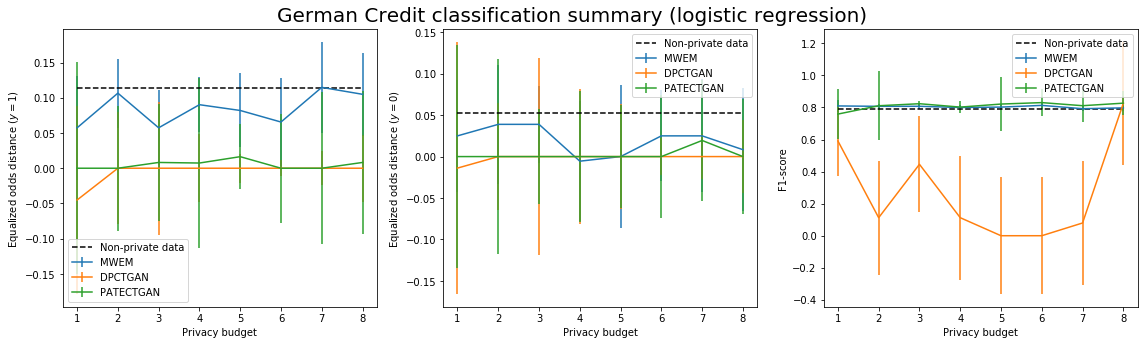

In [24]:
get_german_epsilon_plots(["MWEM", "DPCTGAN", "PATECTGAN"], epsilon_list=epsilons, nreps=15, classifier="logistic", test_df=non_priv_test, f1_metric="median", non_priv_results=True)


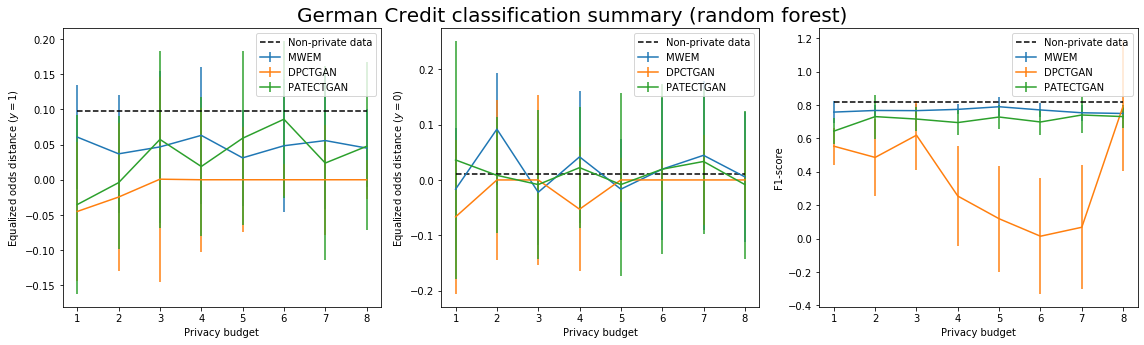

In [26]:
# Plot classification summary for random forest
get_german_epsilon_plots(["MWEM", "DPCTGAN", "PATECTGAN"], epsilon_list=epsilons, nreps=15, classifier="forest", test_df=non_priv_test, f1_metric="median", non_priv_results=True)

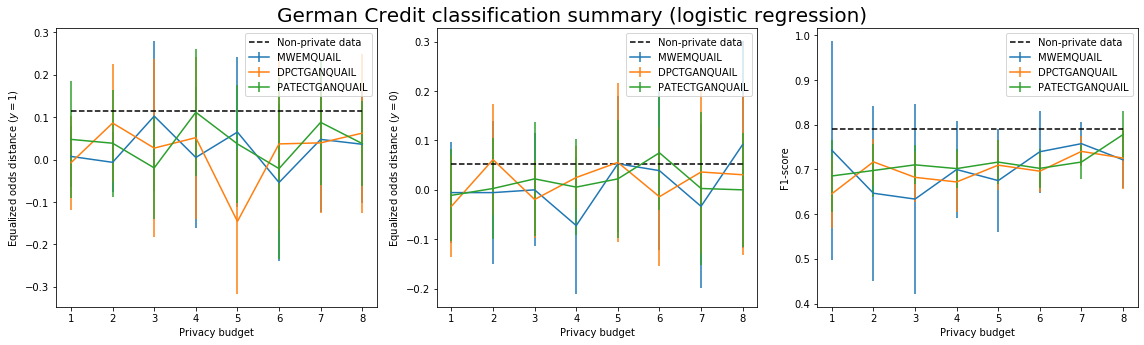

In [29]:
# Plot classification summary for logistic regression
get_german_epsilon_plots(["MWEMQUAIL", "DPCTGANQUAIL", "PATECTGANQUAIL"], epsilon_list=epsilons, nreps=15, classifier="logistic", test_df=non_priv_test, f1_metric="median", non_priv_results=True)


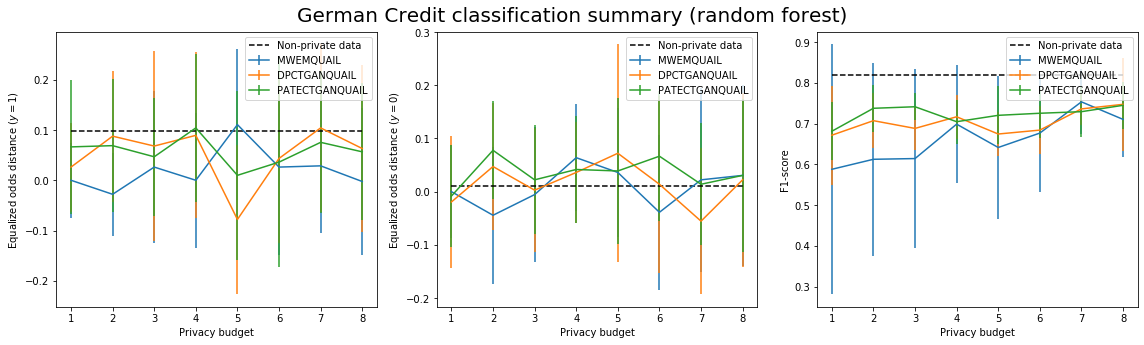

In [31]:
# Plot classification summary for random forest
get_german_epsilon_plots(["MWEMQUAIL", "DPCTGANQUAIL", "PATECTGANQUAIL"], epsilon_list=epsilons, nreps=15, classifier="forest", test_df=non_priv_test, f1_metric="median", non_priv_results=True)